In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# -------------------------------
TRAIN_PATH  = "data/digit-recognizer/train.csv"
TEST_PATH   = "data/digit-recognizer/test.csv"
SUBM_PATH   = "data/digit-recognizer/sample_submission.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)
subm_df  = pd.read_csv(SUBM_PATH)

print("train_df:", train_df.shape)
print("test_df :", test_df.shape)
print("subm_df :", subm_df.shape)

train_df: (42000, 785)
test_df : (28000, 784)
subm_df : (28000, 2)


In [11]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
subm_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
Y_train = train_df["label"].values
X_train = train_df.drop(columns="label").values  # flatten the data frame to a vector for each pixel
X_test  = test_df.values

print("X_train :", X_train.shape)
print("Y_train :", Y_train.shape)
print("X_test:", X_test.shape)

X_train : (42000, 784)
Y_train : (42000,)
X_test: (28000, 784)


In [15]:
pd.Series(Y_train).value_counts().sort_index()

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: count, dtype: int64

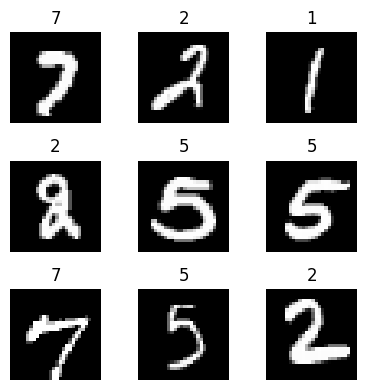

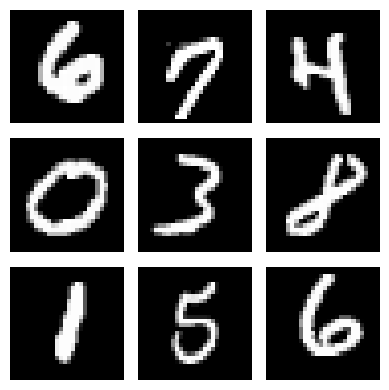

In [16]:
def plot_digits(images, labels=None, n=9):
    rows = int(np.sqrt(n))
    fig, axes = plt.subplots(rows, rows, figsize=(4,4))
    for ax, idx in zip(axes.ravel(), np.random.choice(len(images), n, replace=False)):
        ax.imshow(images[idx].reshape(28,28), cmap="gray")
        if labels is not None:
            ax.set_title(labels[idx])
        ax.axis("off")
    plt.tight_layout(); plt.show()

plot_digits(X_train, labels = Y_train)   # training set
plot_digits(X_test)   

In [ ]:
# Basically convert the gray scale values from 0 to 255 to float values from 0.0 ro 1.1
# 2-a. cast to float32
X_test = X_test.astype(np.float32)
X_train = X_train.astype(np.float32)

# 2-b. scale pixels to [0,1]
X_test /= 255
X_train /= 255 

print("min / max in X_all:", X_test.min(), X_test.max())

min / max in X_all: 0.0 1.0


In [ ]:
VALIDATION_SIZE = 5000 # the acctual testing (validation)

# Build an index array 0 … N-1
indices_all = np.arange(len(X_train))      # X_train still holds 42 000 rows
# Shuffle *in-place* so X and y keep the same order
np.random.seed(42)                         # reproducible shuffle
np.random.shuffle(indices_all)

validation_indices = indices_all[:VALIDATION_SIZE] # 0 to 5000 shuffeled positions
training_indices   = indices_all[VALIDATION_SIZE:] # 5000 to 42000

X_validation, Y_validation = X_train[validation_indices], Y_train[validation_indices] 
X_train,      Y_train      = X_train[training_indices],  Y_train[training_indices]

print("X_train     :", X_train.shape,  Y_train.shape)       # (37000, 784) (37000,)
print("X_validation:", X_validation.shape, Y_validation.shape) # (5000, 784) (5000,)

array([    0,     1,     2, ..., 41997, 41998, 41999], shape=(42000,))

In [19]:

# Hyper-parameters
learning_rate     = 0.01      # step size for gradient descent
number_of_epochs  = 30
mini_batch_size   = 64
number_of_inputs  = 784       # 28 × 28
number_of_classes = 10

In [20]:
# Parameter initialisation
rng = np.random.default_rng(seed=0)

weights_input_to_output = rng.normal(
    loc=0.0, scale=0.01,  # small Gaussian
    size=(number_of_inputs, number_of_classes)   # 784 × 10
).astype(np.float32)

biases_output = np.zeros((1, number_of_classes), dtype=np.float32)

In [ ]:
# Helper functions
